# **Neural steering controller for autonomous parking**

This tutorial implements the physics-driven neural steering controller of the paper titled:

*Fast Planning and Tracking of Complex Autonomous Parking Maneuvers With Optimal Control and Pseudo-Neural Networks*

(available at https://ieeexplore.ieee.org/abstract/document/10309845)

## Initialization

### Import packages

In [51]:
import sys
import os
import torch
import pandas as pd
import scipy as sp

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from neu4mes import *
from neu4mes import relation
from neu4mes import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/Research/Neu4Mes/tutorials


### Configurations, known constant parameters and initial guesses

In [52]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'datasets','control_steer_car_parking')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis]  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis]  # add a dimension

# Initial guesses
# Load the initial guesses for the curvature diagram approximation, computed in Matlab with a 2nd order optimizer
initial_guesses_curv_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_curv_diagram','fit_curv_diagr_5th_ord_poly.mat'))
curv_diagram_params_guess = initial_guesses_curv_diagr['optim_params_poly'][0].astype('float64')

## NN model

### Custom parametric functions

In [53]:
# Curvature diagram
def curvat_diagram(curv,L,h_1,h_2,h_3):
  return torch.atan(h_1*curv + h_2*torch.pow(curv,3) + h_3*torch.pow(curv,5) + curv*L)

# Steering maps
def steer_map_spline(x,x_data,y_data):
  # Inputs: 
  # x: average steering angle at the front wheels [rad]
  # x_data: map of average steering angles at the front wheels (delta_w_avg_map) [rad]
  # y_data: map of steering wheel angles (delta_sw_map) [rad]
  # Output:
  # y: steering wheel angle [rad]

  # Linear interpolation of the steering map:
  # Find the indices of the intervals containing each x
  indices = torch.searchsorted(x_data, x, right=True).clamp(1, len(x_data) - 1)
  
  # Get the values for the intervals
  x1 = x_data[indices - 1]
  x2 = x_data[indices]
  y1 = y_data[indices - 1]
  y2 = y_data[indices]
  
  # Linear interpolation formula
  y = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
  
  # Saturate the output if x is out of bounds
  y = torch.where(x < x_data[0], y_data[0], y)    # Saturate to minimum y_data
  y = torch.where(x > x_data[-1], y_data[-1], y)  # Saturate to maximum y_data
  return y

### Internal architecture

In [54]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# Neural model inputs and outputs
curv         = Input('curv')          # [1/m] path curvature
steer        = Input('steer')         # [rad] steering wheel angle 
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

num_samples_future_curv = 15   # number of samples in the future for the curvature prediction
num_samples_past_steer  = 15   # number of samples in the past for the steering wheel angle prediction

# Non-trainable parameters:
# Vehicle data
L = Constant('L',values=pd.read_csv(vehicle_data_csv)['L'][0])  # [m] wheelbase

# Trainable parameters:
# Curvature diagram parameters
h_1_guess = Parameter('h_1',values=[[curv_diagram_params_guess[0]]])  # initial guess
h_2_guess = Parameter('h_2',values=[[curv_diagram_params_guess[1]]])  # initial guess
h_3_guess = Parameter('h_3',values=[[curv_diagram_params_guess[2]]])  # initial guess

# Parametric function to learn the curvature diagram 
out_curv_diagr = ParamFun(curvat_diagram,
                          constants=[L],
                          parameters=[h_1_guess,h_2_guess,h_3_guess])(curv.sw([0,num_samples_future_curv]))

# FIR layer to weigh the future predictions of the curvature diagram
out_fir        = Fir(parameter='fir_future_curv', parameter_init=init_negexp, 
                     parameter_init_params={'size_index':0, 'first_value':0.1, 'lambda':5})(out_curv_diagr)   

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
delta_w_avg_map = Constant('delta_w_avg_map',values=delta_w_avg_map_values)  # [rad] average steering angle at the front wheels
delta_sw_map    = Constant('delta_sw_map',values=delta_sw_map_values)        # [rad] steering wheel angle
out_steer_map   = ParamFun(steer_map_spline, 
                           constants=[delta_w_avg_map,delta_sw_map],
                           map_over_batch=True)(out_fir)   

# FIR layer to weigh the past steering wheel angles computed by the NN (auto-regressive model)
out_arx        = Fir(parameter='fir_auto_regression', parameter_init=init_negexp, 
                     parameter_init_params={'size_index':0, 'first_value':1e-3, 'lambda':5})(steer.sw([-num_samples_past_steer,0]))  

# Output of the neural model
out = Output('steering_angle', out_steer_map + out_arx)

RuntimeError: torch.searchsorted(): boundaries tensor should be 1 dimension or the first N-1 dimensions of boundaries tensor and input value tensor must match, but we got boundaries tensor [100, 1] and input value tensor [1, 5]

### Neu4Mes framework

In [39]:
# Create a neu4mes model
steer_controller_park = Neu4mes(visualizer='Standard',seed=0,workspace=os.path.join(os.getcwd(),'trained_models'))  #visualizer=MPLVisulizer()

# Add the neural model to the neu4mes structure and neuralization of the model
steer_controller_park.addModel('steer_ctrl',[out])
steer_controller_park.addMinimize('steer_error', 
                                  steer_target.next(),  # next means the first value in the "future"
                                  out, 
                                  loss_function='mse')
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'L': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun43': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'curvat_diagram',
                               'out_dim': {'dim': 1, 'sw': 15},
                               'params_and_consts': ['L', 'h_1', 'h_2', 'h_3']},
               'FParamFun45': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                           

## Training and validation datasets

In [40]:
# Load the training and the validation dataset
data_struct = ['curv',('steer','steer_target')]  # both steer and steer_target are read from the same column of the csv file
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')
data_folder_test  = os.path.join(data_folder,'test')
steer_controller_park.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='test_set', source=data_folder_test, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_park.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

============================ Neu4mes Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      3092
Shape of steer:               (3092, 15, 1)
Shape of curv:                (3092, 15, 1)
Shape of steer_target:        (3092, 1, 1)
============================ Neu4mes Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      832
Shape of steer:               (832, 15, 1)
Shape of curv:                (832, 15, 1)
Shape of steer_target:        (832, 1, 1)
============================ Neu4mes Model Dataset =============================
Dataset Name:                 test_set
Number of files:              1
Total number of samples:      691
Shape of steer:               (691, 15, 1)
Shape of curv:                (691, 15, 1)
Shape of steer_target:        (691, 1, 1)


## Training

### Train the NN in open-loop (no auto-regressive term)

In [41]:
num_epochs = 6000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars_open_loop = {'num_of_epochs':num_epochs, 
                           'val_batch_size':batch_size, 
                           'train_batch_size':batch_size, 
                           'lr':learn_rate}

steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                 training_params=training_pars_open_loop, optimizer='Adam', shuffle_data=True,
                                 early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'patience':early_stop_patience})  

======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
train dataset:                training_set
train {batch size, samples}:  {100, 3092}
val dataset:                  validation_set
val {batch size, samples}:    {100, 832}
num of epochs:                6000
shuffle data:                 True
early stopping:               early_stop_valid_patience
early stopping params:        {'patience': 100}
minimize:                     {'steer_error': {'A': 'SamplePart76',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'fir_auto_regression'},
                               {'params': 'fir_future_curv'},
                               {'params': 'h_1'},
                               {'params': 'h_2'},
                     

KeyboardInterrupt: 

In [18]:
# Print the trained NN parameters
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'L': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun32': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'curvat_diagram',
                               'out_dim': {'dim': 1, 'sw': 15},
                               'params_and_consts': ['L', 'h_1', 'h_2', 'h_3']},
               'FParamFun34': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                           

### Re-train the NN in auto-regressive mode (closed-loop training)

In [19]:
num_epochs = 1000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 50
training_pars_closed_loop = {'num_of_epochs':num_epochs, 
                             'val_batch_size':batch_size, 
                             'train_batch_size':batch_size, 
                             'lr':learn_rate}

predict_samples = 50  # number of samples after which the internal state is reset
steps_skip = 1  # number of samples to skip when going to a new window. The default is 1, meaning the size of a batch. If steps_skip = predict_samples, then the whole window size is skipped

# NOTE: by default, the next batch skips a full length of a batch
# NOTE: shuffle = True shuffles only the order of the batches, so it's ok with the autoregression

steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                 training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=True,
                                 early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'patience':early_stop_patience},
                                 prediction_samples=predict_samples, step=steps_skip, closed_loop={'steer':'steering_angle'})  

Recurrent train: closing the loop between the the input ports steer and the output ports steering_angle for 50 samples
======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
train dataset:                training_set
train {batch size, samples}:  {100, 3092}
val dataset:                  validation_set
val {batch size, samples}:    {100, 832}
num of epochs:                1000
shuffle data:                 True
early stopping:               early_stop_valid_patience
early stopping params:        {'patience': 50}
minimize:                     {'steer_error': {'A': 'SamplePart57',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
prediction samples:           50
step:                         1
closed loop:                  {'steer': 'steering_angle'}
connect:                      {}
optimizer:                    Adam
optimizer defaults:

| 10/1000  |3.907e-02|2.828e-04|3.907e-02|2.828e-04|
| 20/1000  |2.690e-02|2.861e-04|2.690e-02|2.861e-04|
| 30/1000  |7.151e-02|1.112e-03|7.151e-02|1.112e-03|
| 40/1000  |7.837e-03|3.163e-03|7.837e-03|3.163e-03|
| 50/1000  |4.800e-04|1.694e-04|4.800e-04|1.694e-04|
| 53/1000  |3.540e-02|6.062e-03|3.540e-02|6.062e-03|Stopping the training..
============================ Neu4mes Training Time =============================
Total time of Training:       83.48178505897522
================ Neu4mes Model Results for training_set ================
|   Loss   |        mse        |        FVU        |        AIC        |
|          |    small better   |    small better   |    lower better   |
|----------------------------------------------------------------------|
|steer_error|     1.383e-04     |     2.643e-06     |     -1.863e+04    |
|----------------------------------------------------------------------|
|  Total   |     1.383e-04     |     2.643e-06     |     -1.863e+04    |
|-----------------

({'steer_error': [0.04842660576105118,
   0.004839054308831692,
   0.00047264358727261424,
   7.910221756901592e-05,
   3.014383401023224e-05,
   2.6881394660449587e-05,
   0.00018246102263219655,
   0.003469278337433934,
   0.06730366498231888,
   0.03906954824924469,
   0.000572110409848392,
   4.917167098028585e-05,
   3.0983319447841495e-05,
   3.489929440547712e-05,
   6.222995580174029e-05,
   0.0002074271033052355,
   0.0012525316560640931,
   0.010815722867846489,
   0.07275977730751038,
   0.02690318413078785,
   0.0003575072332751006,
   6.199043127708137e-05,
   4.668875044444576e-05,
   5.179834988666698e-05,
   7.609964814037085e-05,
   0.00017057181685231626,
   0.000603812572080642,
   0.0031095773447304964,
   0.019485579803586006,
   0.07150723785161972,
   0.02194399945437908,
   0.000240717243286781,
   7.481543434550986e-05,
   4.4203039578860626e-05,
   5.6665190641069785e-05,
   7.972511957632378e-05,
   0.00014995700621511787,
   0.0004092435701750219,
   0.00158

### Print the parameters of the trained NN

In [20]:
# Print the trained NN parameters
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'L': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun32': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'curvat_diagram',
                               'out_dim': {'dim': 1, 'sw': 15},
                               'params_and_consts': ['L', 'h_1', 'h_2', 'h_3']},
               'FParamFun34': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                           

## Test on a new dataset

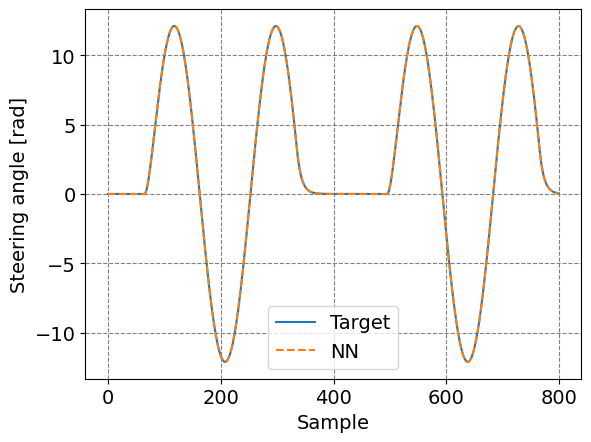

In [34]:
# Test on a new dataset
samples_test_set = steer_controller_park.getSamples('validation_set', index=0, window=800) 
steer_controller_park.resetStates()  # reset the internal state
out_nn_test_set         = steer_controller_park(samples_test_set, sampled=True)
out_nn_test_set_extract = out_nn_test_set['steering_angle']

# extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# plot the results
plt.figure()
plt.plot(samples_test_set_extract,label='Target')
plt.plot(out_nn_test_set_extract,label='NN',linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Steering angle [rad]')
plt.legend()
plt.grid()
plt.show()

# Test with custom data
#steer_controller_park({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})

## Export the trained NN

In [22]:
flag_export_trained_model = False
if flag_export_trained_model:
  # Export the model
  steer_controller_park.neuralizeModel()
  steer_controller_park.exportJSON()

flag_load_trained_model = False
if flag_load_trained_model:
  # Reload the trained model:
  # Load the json file with the model
  json_folder = os.path.join(os.getcwd(),'tutorials','trained_models','neu4mes_2024_10_07_17_50')
  json_file = os.path.join(json_folder,'model.json')
  import json
  # Open and read the JSON file
  with open(json_file, 'r') as file:
      model_trained_json = json.load(file)

  steer_controller_park.model_def = model_trained_json
  # steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
  #                                  training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=True,
  #                                  prediction_samples=predict_samples, step=steps_skip,
  #                                  early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'exit_tol':1-3})  